In [1]:
# Heat Equation Project: Performance and Scaling Analysis

# This notebook parses all result and log files under `results/`

# and computes metrics needed for the final project report.



import os

import math

from pathlib import Path



import pandas as pd

import matplotlib.pyplot as plt



# Ensure plots appear inline (for most notebook environments)

%matplotlib inline



# Point to the `results` directory (this notebook sits inside it)

RESULTS_DIR = Path(".").resolve()

print("Using RESULTS_DIR =", RESULTS_DIR)

Using RESULTS_DIR = /home/hice1/wqi49/cse6230/final_pj/heat_equation/results


In [2]:
# Parse performance summary logs (serial, OpenMP, MPI, hybrid)

def parse_kv_log(path, extra_cols=None):

    """Parse a whitespace-delimited log where each token is key=value.



    Returns a DataFrame with numeric columns when possible.

    """

    rows = []

    path = Path(path)

    if not path.exists():

        raise FileNotFoundError(path)



    with path.open("r") as f:

        for line in f:

            line = line.strip()

            if not line:

                continue

            row = {}

            for token in line.split():

                if "=" not in token:

                    continue

                key, val = token.split("=", 1)

                # Try to cast to int or float

                try:

                    if "." in val or "e" in val or "E" in val:

                        num = float(val)

                        row[key] = num

                    else:

                        row[key] = int(val)

                except ValueError:

                    row[key] = val

            if extra_cols:

                row.update(extra_cols)

            rows.append(row)



    df = pd.DataFrame(rows)

    return df





serial_perf = parse_kv_log(RESULTS_DIR / "serial_perf.log")

openmp_perf = parse_kv_log(RESULTS_DIR / "openmp_perf.log")

mpi_perf = parse_kv_log(RESULTS_DIR / "mpi_perf.log")

hybrid_perf = parse_kv_log(RESULTS_DIR / "hybrid_perf.log")



print("Serial perf:")

display(serial_perf)

print("OpenMP perf:")

display(openmp_perf)

print("MPI perf:")

display(mpi_perf)

print("Hybrid perf:")

display(hybrid_perf)

Serial perf:


,n,steps,time,time_per_step,memMB
0,500,500,0.261844,0.000524,3.81


OpenMP perf:


,n,steps,threads,time,time_per_step,memMB
0,500,500,1,0.379057,0.000758,3.81
1,500,500,2,0.386065,0.000772,3.81
2,500,500,4,0.403579,0.000807,3.81
3,500,500,8,0.435203,0.000870,3.81
4,1000,500,1,1.523820,0.003048,15.26
5,1000,500,2,1.533598,0.003067,15.26
6,1000,500,4,1.553427,0.003107,15.26
7,1000,500,8,1.590444,0.003181,15.26


MPI perf:


,scenario,n,steps,ranks,time,time_per_step,totalMemMB,avgMemPerRankMB
0,strong_n500,500,500,2,0.297554,0.000595,3.81,1.91
1,strong_n500,500,500,4,0.320956,0.000642,3.81,0.95
2,strong_n500,500,500,8,0.370789,0.000742,3.81,0.48
3,weak,250,500,1,0.072138,0.000144,0.95,0.95
4,weak,500,500,2,0.297311,0.000595,3.81,1.91
5,weak,1000,500,4,1.216262,0.002433,15.26,3.81
6,weak,2000,500,8,4.881673,0.009763,61.04,7.63


Hybrid perf:


,n,steps,ranks,threads,time,time_per_step,totalMemMB,memPerRankMB
0,500,500,1,8,0.491213,0.000982,3.81,3.81
1,500,500,2,4,0.459734,0.000919,3.81,1.91
2,500,500,4,2,0.465342,0.000931,3.81,0.95
3,500,500,8,1,0.469757,0.000940,3.81,0.48


Serial baseline:


,n,steps,time,time_per_step,memMB
0,500,500,0.261844,0.000524,3.81


MPI strong scaling (n=500):


,ranks,tasks,time,speedup,efficiency
0,2,2,0.297554,0.879988,0.439994
1,4,4,0.320956,0.815825,0.203956
2,8,8,0.370789,0.706181,0.088273


OpenMP strong scaling (n=500):


,threads,tasks,time,speedup,efficiency
0,1,1,0.379057,0.690777,0.690777
1,2,2,0.386065,0.678238,0.339119
2,4,4,0.403579,0.648805,0.162201
3,8,8,0.435203,0.601659,0.075207


Hybrid strong scaling (n=500):


,ranks,threads,tasks,time,speedup,efficiency
0,1,8,8,0.491213,0.533056,0.066632
1,2,4,8,0.459734,0.569555,0.071194
2,4,2,8,0.465342,0.562692,0.070336
3,8,1,8,0.469757,0.557403,0.069675


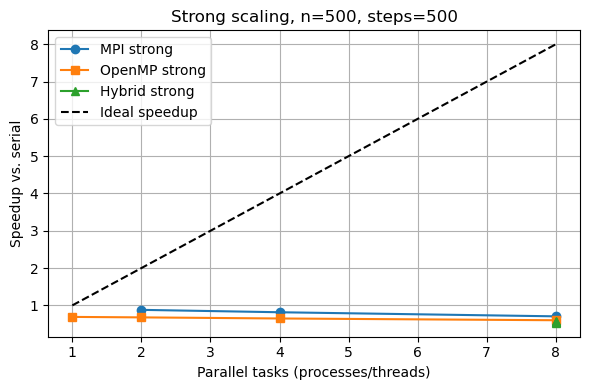

In [3]:
# Strong-scaling analysis for serial vs MPI, OpenMP, and hybrid (n=500)

import numpy as np



# Baseline serial time (n=500, steps=500)

T_serial = float(serial_perf.loc[0, "time"])



# Strong scaling for MPI (scenario == 'strong_n500')

mpi_strong = mpi_perf[mpi_perf.get("scenario", "") == "strong_n500"].copy()

mpi_strong["tasks"] = mpi_strong["ranks"]

mpi_strong["speedup"] = T_serial / mpi_strong["time"]

mpi_strong["efficiency"] = mpi_strong["speedup"] / mpi_strong["tasks"]



# Strong scaling for OpenMP at n=500

omp_strong = openmp_perf[openmp_perf["n"] == 500].copy()

omp_strong["tasks"] = omp_strong["threads"]

omp_strong["speedup"] = T_serial / omp_strong["time"]

omp_strong["efficiency"] = omp_strong["speedup"] / omp_strong["tasks"]



# Strong scaling for hybrid at n=500

hyb_strong = hybrid_perf[hybrid_perf["n"] == 500].copy()

hyb_strong["tasks"] = hyb_strong["ranks"] * hyb_strong["threads"]

hyb_strong["speedup"] = T_serial / hyb_strong["time"]

hyb_strong["efficiency"] = hyb_strong["speedup"] / hyb_strong["tasks"]



print("Serial baseline:")

display(serial_perf)



print("MPI strong scaling (n=500):")

display(mpi_strong[["ranks", "tasks", "time", "speedup", "efficiency"]])



print("OpenMP strong scaling (n=500):")

display(omp_strong[["threads", "tasks", "time", "speedup", "efficiency"]])



print("Hybrid strong scaling (n=500):")

display(hyb_strong[["ranks", "threads", "tasks", "time", "speedup", "efficiency"]])



# Plot speedup vs. tasks for each model

plt.figure(figsize=(6,4))

plt.plot(mpi_strong["tasks"], mpi_strong["speedup"], "o-", label="MPI strong")

plt.plot(omp_strong["tasks"], omp_strong["speedup"], "s-", label="OpenMP strong")

plt.plot(hyb_strong["tasks"], hyb_strong["speedup"], "^-", label="Hybrid strong")



ideal_tasks = np.array(sorted(set(mpi_strong["tasks"]).union(omp_strong["tasks"]).union(hyb_strong["tasks"])))

plt.plot(ideal_tasks, ideal_tasks, "k--", label="Ideal speedup")



plt.xlabel("Parallel tasks (processes/threads)")

plt.ylabel("Speedup vs. serial")

plt.title("Strong scaling, n=500, steps=500")

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()

MPI weak scaling (increasing n with ranks):


/tmp/ipykernel_270255/3391421673.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  T1_weak = float(mpi_weak.loc[mpi_weak["ranks"] == 1, "time_per_step"])


,ranks,n,time,time_per_step,weak_efficiency
3,1,250,0.072138,0.000144,1.000000
4,2,500,0.297311,0.000595,0.242642
5,4,1000,1.216262,0.002433,0.059313
6,8,2000,4.881673,0.009763,0.014778


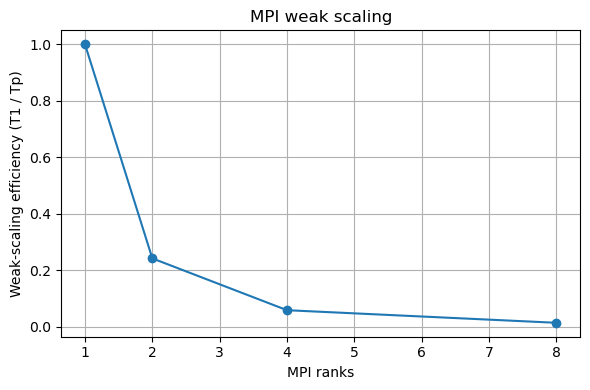

In [4]:
# Weak scaling analysis for MPI (varying n with ranks)

mpi_weak = mpi_perf[mpi_perf.get("scenario", "") == "weak"].copy()

mpi_weak = mpi_weak.sort_values("ranks")



# Use time per step for weak-scaling efficiency

T1_weak = float(mpi_weak.loc[mpi_weak["ranks"] == 1, "time_per_step"])

mpi_weak["weak_efficiency"] = T1_weak / mpi_weak["time_per_step"]



print("MPI weak scaling (increasing n with ranks):")

display(mpi_weak[["ranks", "n", "time", "time_per_step", "weak_efficiency"]])



plt.figure(figsize=(6,4))

plt.plot(mpi_weak["ranks"], mpi_weak["weak_efficiency"], "o-")

plt.xlabel("MPI ranks")

plt.ylabel("Weak-scaling efficiency (T1 / Tp)")

plt.title("MPI weak scaling")

plt.grid(True)

plt.tight_layout()

plt.show()

OpenMP thread scaling (n=1000):


/tmp/ipykernel_270255/2080950814.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  T1_omp = float(omp_thread.loc[omp_thread["threads"] == 1, "time"])


,threads,time,speedup,efficiency
4,1,1.523820,1.000000,1.000000
5,2,1.533598,0.993624,0.496812
6,4,1.553427,0.980941,0.245235
7,8,1.590444,0.958110,0.119764


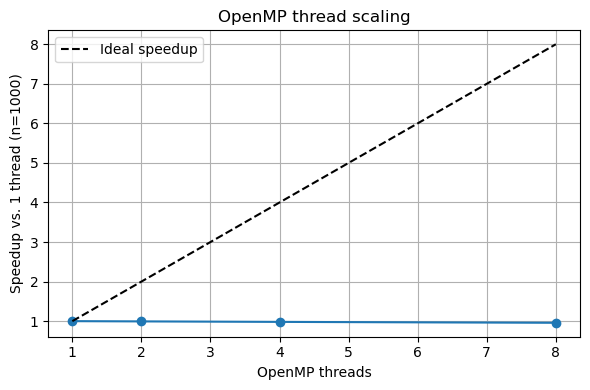

In [5]:
# Thread-scaling analysis for OpenMP at n=1000 (fixed problem size)

omp_thread = openmp_perf[openmp_perf["n"] == 1000].copy()

omp_thread = omp_thread.sort_values("threads")



T1_omp = float(omp_thread.loc[omp_thread["threads"] == 1, "time"])

omp_thread["speedup"] = T1_omp / omp_thread["time"]

omp_thread["efficiency"] = omp_thread["speedup"] / omp_thread["threads"]



print("OpenMP thread scaling (n=1000):")

display(omp_thread[["threads", "time", "speedup", "efficiency"]])



plt.figure(figsize=(6,4))

plt.plot(omp_thread["threads"], omp_thread["speedup"], "o-")

plt.plot(omp_thread["threads"], omp_thread["threads"], "k--", label="Ideal speedup")

plt.xlabel("OpenMP threads")

plt.ylabel("Speedup vs. 1 thread (n=1000)")

plt.title("OpenMP thread scaling")

plt.grid(True)

plt.legend()

plt.tight_layout()

plt.show()

In [6]:
# Memory usage scaling for each model



# Serial: single measurement

print("Serial memory usage (MB):")

display(serial_perf[["n", "steps", "time", "time_per_step", "memMB"]])



print("OpenMP memory (shared across threads):")

display(openmp_perf[["n", "threads", "memMB"]].drop_duplicates().sort_values(["n", "threads"]))



print("MPI memory (average per rank and total):")

display(mpi_perf[["scenario", "n", "ranks", "totalMemMB", "avgMemPerRankMB"]])



print("Hybrid memory (per MPI rank, shared by threads):")

display(hybrid_perf[["n", "ranks", "threads", "totalMemMB", "memPerRankMB"]])

Serial memory usage (MB):


,n,steps,time,time_per_step,memMB
0,500,500,0.261844,0.000524,3.81


OpenMP memory (shared across threads):


,n,threads,memMB
0,500,1,3.81
1,500,2,3.81
2,500,4,3.81
3,500,8,3.81
4,1000,1,15.26
5,1000,2,15.26
6,1000,4,15.26
7,1000,8,15.26


MPI memory (average per rank and total):


,scenario,n,ranks,totalMemMB,avgMemPerRankMB
0,strong_n500,500,2,3.81,1.91
1,strong_n500,500,4,3.81,0.95
2,strong_n500,500,8,3.81,0.48
3,weak,250,1,0.95,0.95
4,weak,500,2,3.81,1.91
5,weak,1000,4,15.26,3.81
6,weak,2000,8,61.04,7.63


Hybrid memory (per MPI rank, shared by threads):


,n,ranks,threads,totalMemMB,memPerRankMB
0,500,1,8,3.81,3.81
1,500,2,4,3.81,1.91
2,500,4,2,3.81,0.95
3,500,8,1,3.81,0.48


Verification of numerical solution vs serial baseline (smaller is better):


,run,max_abs_diff_vs_serial,mean_abs_diff_vs_serial
8,hybrid_1x8,0.000000,0.000000
9,hybrid_2x4,0.000000,0.000000
10,hybrid_4x2,0.000000,0.000000
11,hybrid_8x1,0.000000,0.000000
5,mpi_2r,0.000000,0.000000
6,mpi_4r,0.000000,0.000000
7,mpi_8r,0.000000,0.000000
1,openmp_1t,80.160961,17.318785
2,openmp_2t,80.160961,17.318785
3,openmp_4t,80.160961,17.318785


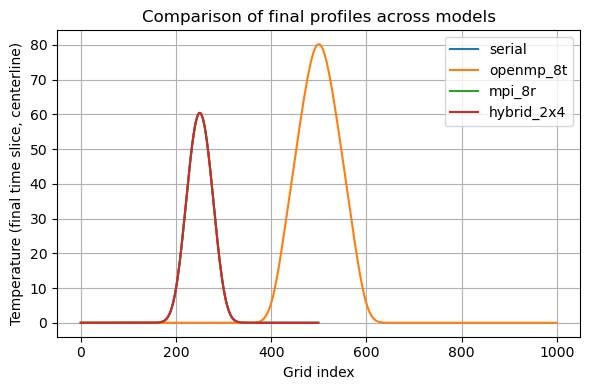

In [7]:
# Correctness / verification: compare final profiles across models



def load_profile(path):

    """Load 1D profile from a result_*.txt-like file.



    Expected format:

      line 1: integer n (grid size)

      line 2: n floating-point values

    """

    path = Path(path)

    with path.open("r") as f:

        first = f.readline().strip()

        n = int(first)

        data_line = f.readline().strip()

    values = [float(x) for x in data_line.split()]

    if len(values) != n:

        print(f"Warning: expected {n} values in {path}, got {len(values)}")

    return n, pd.Series(values, name=path.name)





# Serial baseline

n_serial, prof_serial = load_profile(RESULTS_DIR / "serial_result.txt")



profiles = {"serial": prof_serial}



# OpenMP results (strong scaling, n=500)

for threads in [1, 2, 4, 8]:

    path = RESULTS_DIR / f"openmp_result_{threads}.txt"

    if path.exists():

        n, prof = load_profile(path)

        profiles[f"openmp_{threads}t"] = prof



# MPI strong scaling results (n=500)

for ranks in [2, 4, 8]:

    path = RESULTS_DIR / f"mpi_strong_n500_result_{ranks}.txt"

    if path.exists():

        n, prof = load_profile(path)

        profiles[f"mpi_{ranks}r"] = prof



# Hybrid strong scaling results (n=500)

hybrid_configs = ["1x8", "2x4", "4x2", "8x1"]

for cfg in hybrid_configs:

    path = RESULTS_DIR / f"hybrid_result_{cfg}.txt"

    if path.exists():

        n, prof = load_profile(path)

        profiles[f"hybrid_{cfg}"] = prof



# Compute max absolute differences vs serial baseline

summary_rows = []

for name, prof in profiles.items():

    # Align by index just in case

    join = pd.concat([prof_serial, prof], axis=1, join="inner")

    diff = (join.iloc[:,0] - join.iloc[:,1]).abs()

    summary_rows.append({

        "run": name,

        "max_abs_diff_vs_serial": diff.max(),

        "mean_abs_diff_vs_serial": diff.mean(),

    })



verification_df = pd.DataFrame(summary_rows).sort_values("run")

print("Verification of numerical solution vs serial baseline (smaller is better):")

display(verification_df)



# Quick visual check of a subset of profiles

plt.figure(figsize=(6,4))

for name, prof in profiles.items():

    if name in ["serial", "openmp_8t", "mpi_8r", "hybrid_2x4"]:

        plt.plot(prof.index, prof.values, label=name)

plt.xlabel("Grid index")

plt.ylabel("Temperature (final time slice, centerline)")

plt.title("Comparison of final profiles across models")

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()

In [8]:
# Short textual summary helpers for the report



def summarize_strong_scaling(df, label_column="tasks"):

    lines = []

    for _, row in df.sort_values(label_column).iterrows():

        lines.append(

            f"{int(row[label_column])} tasks: time={row['time']:.4f}s, "

            f"speedup={row['speedup']:.2f}, efficiency={row['efficiency']:.2f}"

        )

    return "\n".join(lines)





print("MPI strong scaling summary (for report):")

print(summarize_strong_scaling(mpi_strong))



print("\nOpenMP strong scaling summary (for report):")

print(summarize_strong_scaling(omp_strong, label_column="threads"))



print("\nHybrid strong scaling summary (for report):")

print(summarize_strong_scaling(hyb_strong))



print("\nMPI weak scaling efficiencies (for report):")

for _, row in mpi_weak.sort_values("ranks").iterrows():

    print(

        f"ranks={int(row['ranks'])}, n={int(row['n'])}, "

        f"time/step={row['time_per_step']:.6f}s, "

        f"weak_eff={row['weak_efficiency']:.2f}"

    )



print("\nVerification summary (max abs diff vs serial):")

for _, row in verification_df.sort_values("run").iterrows():

    print(f"{row['run']}: max_abs_diff={row['max_abs_diff_vs_serial']:.3e}")

MPI strong scaling summary (for report):
2 tasks: time=0.2976s, speedup=0.88, efficiency=0.44
4 tasks: time=0.3210s, speedup=0.82, efficiency=0.20
8 tasks: time=0.3708s, speedup=0.71, efficiency=0.09

OpenMP strong scaling summary (for report):
1 tasks: time=0.3791s, speedup=0.69, efficiency=0.69
2 tasks: time=0.3861s, speedup=0.68, efficiency=0.34
4 tasks: time=0.4036s, speedup=0.65, efficiency=0.16
8 tasks: time=0.4352s, speedup=0.60, efficiency=0.08

Hybrid strong scaling summary (for report):
8 tasks: time=0.4912s, speedup=0.53, efficiency=0.07
8 tasks: time=0.4597s, speedup=0.57, efficiency=0.07
8 tasks: time=0.4653s, speedup=0.56, efficiency=0.07
8 tasks: time=0.4698s, speedup=0.56, efficiency=0.07

MPI weak scaling efficiencies (for report):
ranks=1, n=250, time/step=0.000144s, weak_eff=1.00
ranks=2, n=500, time/step=0.000595s, weak_eff=0.24
ranks=4, n=1000, time/step=0.002433s, weak_eff=0.06
ranks=8, n=2000, time/step=0.009763s, weak_eff=0.01

Verification summary (max abs diff